# Bibliotecas e configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import PyBCOPS as pb

np.random.seed(123)

# Gerando o conjunto de dados

In [2]:
X_train = np.zeros((1000, 10))
y_train = np.zeros(1000)

X_test = np.zeros((1500, 10))
y_test = np.zeros(1500)

for i in range(500):
    ## Dados para o treino
    # Classe 1
    X_train[i,:] = np.random.normal(0, 1, 10)
    y_train[i] = 0
    
    # Classe 2
    X_train[i + 500,] = np.concatenate([np.random.normal(3, 0.5, 1), np.random.normal(0, 1, 9)])
    y_train[i + 500] = 1
    
    ## Dados para o teste
    # Classe 1
    X_test[i,:] = np.random.normal(0, 1, 10)
    y_test[i] = 0
    
    # Classe 2
    X_test[i + 500,:] = np.concatenate([np.random.normal(3, 0.5, 1), np.random.normal(0, 1, 9)])
    y_test[i + 500] = 1
    
    # Classe 3 (outliers)
    X_test[i + 1000,:] = np.concatenate([np.random.normal(0, 1, 1),
                                        np.random.normal(3, 0.5, 1),
                                        np.random.normal(0, 1, 8)])
    y_test[i + 1000] = 2

## Visualização do conjunto de treinamento

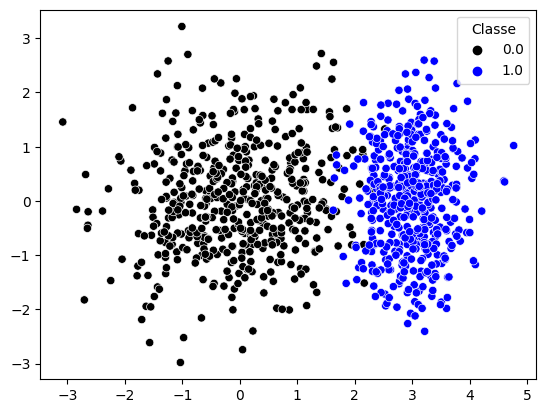

In [3]:
sns.scatterplot(x = X_train[:,0], y = X_train[:,1], hue = y_train, palette=['black', 'blue'])
plt.legend(title = "Classe")

## Visualização do conjunto de teste

Perceba que o conjunto de teste possui uma classe que seguem um padrão diferente das presentes no conjunto de treinamento. As observações dessa classe devem ser consideradas como atípicas pelo algoritmo BCOPS.

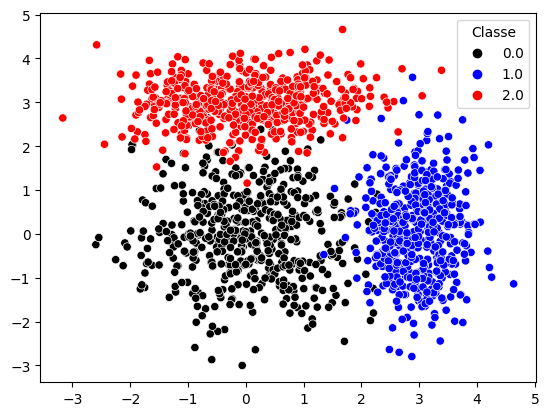

In [4]:
sns.scatterplot(x = X_test[:,0], y = X_test[:,1], hue = y_test, palette=['black', 'blue', 'red'])
plt.legend(title = "Classe")

# Treinamento do algoritmo

## Data-splitting

In [5]:
foldid = np.random.randint(1, 3, len(y_train))
foldid_te = np.random.randint(1, 3, len(y_test))

xtrain1 = X_train[foldid==1,:]
xtrain2 = X_train[foldid==2,:]
ytrain1 = y_train[foldid==1]
ytrain2 = y_train[foldid==2]
xtest1 = X_test[foldid_te ==1,:]
xtest2 = X_test[foldid_te==2,:]
labels = np.unique(y_train)

## Treinamento

In [6]:
bcops = pb.BCOPS(RandomForestClassifier, xtrain1, ytrain1, xtrain2, ytrain2, xtest1, xtest2, labels)

prediction_conformal = np.zeros((len(y_test), len(labels)))
prediction_conformal[foldid_te==1,:] = bcops['conformal_scores1']
prediction_conformal[foldid_te==2,:] = bcops['conformal_scores2']

## Visualização das classes preditas

No gráfico, uma observação que teve a classe predita como 2 é considerada atípica. Já as observações classificadas como 3 podem ser tanto da classe 0 como da classe 1.

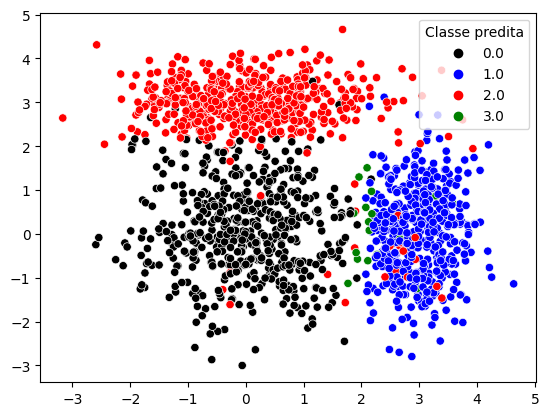

In [7]:
alpha = 1-0.95

y_pred = np.zeros(prediction_conformal.shape[0])

for i in range(prediction_conformal.shape[0]):
    pred = (prediction_conformal[i,:] > alpha)

    if not (pred[0] or pred[1]):
        y_pred[i] = 2 # outlier
    elif pred[0] and pred[1]:
        y_pred[i] = 3 # ambas as classes
    else:
        y_pred[i] = labels[pred][0] # apenas uma das classes

sns.scatterplot(x = X_test[:,0], y = X_test[:,1], hue = y_pred, palette=['black', 'blue', 'red', 'green'])
plt.legend(title = "Classe predita")

## Matriz de confusão e taxa de detecção de observações atípicas

As linhas indicam a classe verdadeira e as colunas indicam a classe predita no conjunto de teste.

In [8]:
pb.evaluate_conformal(prediction_conformal, y_test, labels)

,0.0,1.0
0.0,0.952,0.026
1.0,0.044,0.932
2.0,0.046,0.004


Podemos notar que aproximadamente $95\%$ das observações cujas classes estavam presentes durante o treinamento são classificadas corretamente.

In [9]:
np.mean(y_pred[1000:1500] == 2)

0.95

Temos ainda uma taxa de detecção de observações atípicas de $95\%$